# This version of the notebook will include the new features introduced in ipyaladin v0.5.2.

To Do:
- [] Remove some data sets from this example
- [] Add image cutouts from the DL image cutout tool
- [] Import dataset from DL to overplot on Aladin

In [1]:
__author__ = 'Brian Merino <brian.merino@noirlab.edu>'
__version__ = '2024' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['Aladin','smash','des','delve']

# Displaying MOCs and HiPs in Aladin Lite v3

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimers and attribution](#disclaimer)
* [Imports and setup](#imports)
* [Create MOCs](#Create_MOCs)
* [About the dataset](#About)
* [Downloading data for reduction](#Downloading_Data)
* [Set up the DRAGONS logger](#DRAGONS_logger)
* [Create File Lists](#File_Lists)
* [Create Master Dark](#Master_dark)
* [Create Bad Pixel Mask](#BPM)
* [Create Master Flat Field](#Master_Flat)
* [Reduce Science Images](#Reduce_Science)
* [Display stacked final image](#Display_Image)
* [Clean-up (optional)](#Clean-up)

<a class="anchor" id="goals"></a>
# Goals
Showcase how to create Multi-Order Coverage maps (MOCs) and Hierarchical Progressive Surveys (HiPS) and display them on the Aladin Lite viewer.

The steps include downloading data from the Astro DataLab's data explorer, turning the data into MOCs and HiPs files, establish a local instance of the Aladin Lite viewer, and finally, display the files and explorer Aladin.


<a class="anchor" id="summary"></a>
# Summary
Aladin Lite is an interactable sky atlas that runs in your browser. 

Aladin makes it possible to explore the sky and has built in functionality that makes it possible to overlay images onto the map and identify objects included in databases. 

HiPS catalogs make it possible to see the locations of objects on the sky while MOCs display the footprints of surveys. MOCs make it possible to visualize overlaps in various surveys.

This notebook will demonstrate how to create and overlay several MOC files onto Aladin which would help identify overlapping datasets. It could also assist in preparing for a telescope proposal as you would be able to see whether or not any of the datasets hosted by the datalab contain the source of interest. 

In addition to MOCs, this notebook will also generate and display HiPs catlogs. While MOCs visualize survey footprints, HiPS will identify individual sources and provide information about each source when you place your curser over their points on Aladin. 


<a class="anchor" id="disclaimer"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., <a href="http://dx.doi.org/10.1117/12.2057445">"The NOAO Data Laboratory: a conceptual overview"</a>, SPIE, 9149, 2014

* <a href="https://datalab.noirlab.edu/disclaimers.php">Data Lab disclaimer</a>

* DRAGONS publication: Labrie et al., <a href="https://ui.adsabs.harvard.edu/abs/2019ASPC..523..321L/abstract">"DRAGONS - Data Reduction for Astronomy from Gemini Observatory North and South"</a>, ASPC, 523, 321L 

* <a href="https://zenodo.org/record/7776065#.ZDg5qOzMLUI">DRAGONS open source software publication</a>

<a class="anchor" id="imports"></a>
# Imports and setup

This is the setup that is required to use the query client. The first thing to do is import the relevant Python modules.

In [2]:
!pip install ipyaladin mocpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [1]:
# Standard lib
from getpass import getpass

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

import astropy.units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astropy.table import Table
from astropy.table import QTable

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from mocpy import MOC

from ipyaladin import Aladin

In [2]:
import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

import numpy as np
from numpy.core.defchararray import startswith

from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.visualization import make_lupton_rgb

%matplotlib inline

In [3]:
#If this cell does not print out 
#'version: 0.5.2 running Aladin Lite: 3.5.1-beta' 

from ipyaladin import __version__, __aladin_lite_version__
print("version:", __version__, "running Aladin Lite:", __aladin_lite_version__)

version: 0.5.2 running Aladin Lite: 3.5.1-beta


In [4]:
from sidecar import Sidecar

In [5]:
aladin = Aladin()
with Sidecar(title='aladin_output'):
    display(aladin)

In [6]:
aladin.target = "M1"

In [7]:
# # Images from the Sloan Digital Sky Survey DR9
# DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/sdss_dr9"
# svc_sdss_dr9 = sia.SIAService(DEF_ACCESS_URL)

In [8]:
# DECam images from Legacy Surveys DR9
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/ls_dr9"
svc_ls_dr9 = sia.SIAService(DEF_ACCESS_URL)

In [9]:
ra = 159.815 # in degrees
dec = -0.655 # in degrees
fov = 15 # in degrees

#imgTable = svc_sdss_dr9.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
imgTable = svc_ls_dr9.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

In [10]:
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-blobmodel-g.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0",image/fits,50639,,,3,0,0,0,[],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-1598m007-blobmodel-g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-blobmodel-g.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0&preview=true",,,159.875,-0.749998,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,22.5,blobmodel,0,0,,0,,Stack,2014-12-30T08:20:51.181,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-blobmodel-z.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0",image/fits,50639,,,3,0,0,0,[],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,z,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-1598m007-blobmodel-z.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-blobmodel-z.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0&preview=true",,,159.875,-0.749998,--,,,--,8500.0,10020.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,22.5,blobmodel,0,0,,0,,Stack,2014-12-30T08:25:48.461,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-chi2-g.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0",image/fits,11351,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,g DECam SDSS c0001 4720.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-1598m007-chi2-g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-chi2-g.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0&preview=true",,,159.875,-0.749998,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,chi2,0,0,,0,,Stack,,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-chi2-r.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0",image/fits,11334,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,r DECam SDSS c0002 6415.0 1480.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-1598m007-chi2-r.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-chi2-r.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0&preview=true",,,159.875,-0.749998,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,chi2,0,0,,0,,Stack,,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-chi2-z.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0",image/fits,11570,,,3,0,0,2

In [11]:
sel = (imgTable['prodtype'] == 'image') 

In [12]:
row = imgTable[sel]
row

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-image-g.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0",image/fits,11742,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,g DECam SDSS c0001 4720.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-1598m007-image-g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-image-g.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0&preview=true",,,159.875,-0.749998,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,image,0,0,,0,,Stack,,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-image-r.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0",image/fits,13536,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,r DECam SDSS c0002 6415.0 1480.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-1598m007-image-r.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-image-r.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0&preview=true",,,159.875,-0.749998,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,image,0,0,,0,,Stack,,,0


In [13]:
row = imgTable[sel][1]
url = row['access_url'] # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header
wcs = WCS(hdr)

In [15]:
hdu.writeto('test_fits.fits',overwrite=True)

In [16]:
url

'https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-1598m007-image-r.fits.fz&extn=1&POS=159.815,-0.655&SIZE=15.000980217040144,15.0'

-0.039214235 88.21342 (3600, 3600)


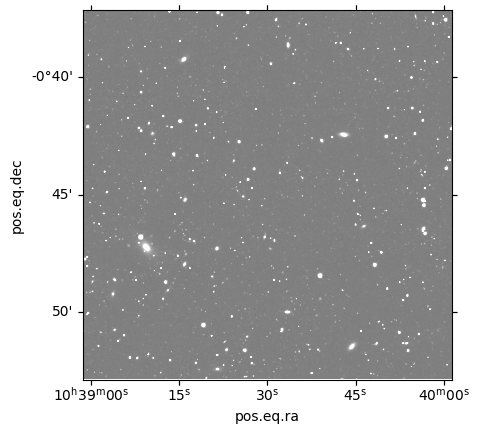

In [17]:
print(image.min(),image.max(),image.shape)
ax = plt.subplot(projection=wcs)
#ax.imshow(image,cmap='gray',vmin=image.min(),vmax=image.min()+(image.max()-image.min())/100.)
ax.imshow(image,cmap='gray',vmin=-0.05,vmax=0.05)
plt.show()

In [18]:
aladin = Aladin()
with Sidecar(title="aladin_output"):
    display(aladin)

In [19]:
aladin.add_fits('test_fits.fits',name='test')

# Accessing the data

To create the MOC that we will ultimately overlay onto Aladin, we are going to use the mocpy library. 

The first thing we will need to do is obtain the data from the Astro Data Lab. For this example, we will be working with data from three different surveys; The **DE**Cam **L**ocal **V**olume **E**xploration Survey [**DELVE**](https://datalab.noirlab.edu/delve/index.php), The **S**urvey of the **MA**gellanic **S**tellar **H**istory [**SMASH**](https://datalab.noirlab.edu/smash/smash.php), and The **D**ark **E**negery **S**urvey [**DES**](https://datalab.noirlab.edu/des/index.php).

# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [ ]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#print(token)
ac.whoAmI()

In [ ]:
query = 'SELECT TOP 25000 ra, dec, mag_auto_g, random_id FROM des_dr2.main WHERE random_id BETWEEN 25.0 AND 25.01'
#response = qc.query(sql = query, fmt = 'csv', out='vos://des_dr2.csv')
df = qc.query(sql = query, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df['index'] = list(range(0,len(df)))

df['survey'] = 'des_dr2'

print('des_dr2 catalog')
print (df)

In [ ]:
query2 = 'SELECT TOP 25000 ra, dec, mag_auto_g, random_id FROM delve_dr2.objects WHERE random_id BETWEEN 25.0 AND 25.01'
#response2 = qc.query(sql = query2, fmt = 'csv', out='vos://delve_dr2.csv')
df2 = qc.query(sql = query2, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df2['index'] = list(range(0,len(df2)))

df2['survey'] = 'delve_dr2'

print('delve_dr2 catalog')
print (df2)

In [ ]:
query3 = 'SELECT TOP 25000 ra, dec, gmag, random_id FROM smash_dr2.object WHERE random_id BETWEEN 25.0 AND 25.01'
#response3 = qc.query(sql = query3, fmt = 'csv', out='vos://smash_dr2.csv')
df3 = qc.query(sql = query3, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df3['index'] = list(range(0,len(df3)))

df3['survey'] = 'smash_dr2'

print('smash_dr2')
print (df3)

In [ ]:
query4 = 'SELECT TOP 25000 ra, dec, f378_petro, random_id FROM splus_dr2.main WHERE random_id BETWEEN 25.0 AND 25.1'
#response3 = qc.query(sql = query3, fmt = 'csv', out='vos://smash_dr2.csv')
df4 = qc.query(sql = query4, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df4['index'] = list(range(0,len(df4)))

df4['survey'] = 'splus_dr2'

print('splus_dr2')
print (df4)

In [ ]:
query5 = 'SELECT TOP 25000 ra, dec, mean_r, random_id FROM decaps_dr2.object WHERE random_id BETWEEN 25.0 AND 25.1'
df5 = qc.query(sql = query5, fmt = 'pandas')

#Lets add an additional column assigning a unique index to each data point.
df5['index'] = list(range(0,len(df5)))

df5['survey'] = 'decaps_dr2'

print('decaps_dr2')
print (df5)

# Now that all three datasets have been downloaded, we can now create Multi-Order Coverage maps (MOCs) for each of them using the mocpy library. 

In [ ]:
def prepare(columns, dataframe, max_norder):
    '''
    This function will perform 2 tasks:
    (1) Read in columns of a dataframe and output a dictionary that is compatible with Aladin Lite

    (2) Use the ra and dec info from the dictionary to create a MOC.
    '''
    #Define a dictionary
    col_dict = {}
    
    #Read each item in provided list and extract the values from the dataframe. Assign values to dictionary.
    for c in columns:
        col_dict[c] = dataframe[c].values
        
    #Now we are going to establish our MOC  
    #Provide MOC.from_longlat() with ra and dec in degrees
    #max_norder:The depth of the smallest HEALPix cells contained in the MOC. Min = 1 | Max = 10
    moc = MOC.from_lonlat(
              col_dict['ra'].transpose() * u.deg,
              col_dict['dec'].transpose() * u.deg,
              max_norder=max_norder)

    return col_dict, moc

In [ ]:
des_list = ['ra','dec','index','mag_auto_g','survey']
des_dict, des_dr2_moc = prepare(des_list, df, max_norder=5)

In [ ]:
delve_list = ['ra','dec','index','mag_auto_g','survey']
delve_dict, delve_dr2_moc = prepare(delve_list, df2, max_norder=5)

In [ ]:
smash_list = ['ra','dec','index','gmag','survey']
smash_dict, smash_dr2_moc = prepare(smash_list, df3, max_norder=5)

In [ ]:
splus_list = ['ra','dec','index','f378_petro','survey']
splus_dict, splus_dr2_moc = prepare(splus_list, df4, max_norder=5)

In [ ]:
decaps_list = ['ra','dec','index','mean_r','survey']
decaps_dict, decaps_dr2_moc = prepare(decaps_list, df5, max_norder=5)

In [ ]:
def plot(moc, color, legend, title=""):
    fig = plt.figure(figsize=(15, 10))

    for c,m in enumerate(moc):
        wcs = WCS(naxis=2)
        wcs.wcs.ctype = ["GLON-AIT", "GLAT-AIT"] #Hammer-Aitoff projection
        wcs.wcs.crval = [300.0, 0.0]             #Specify the value of the reference pixel
        wcs.wcs.cdelt = [-0.675, 0.675]
        wcs.wcs.crpix = [240.5, 120.5]
    
        if c == 0:
            ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)
            patches = []
    
        m.fill(
            ax=ax,
            wcs=wcs,
            edgecolor=color[c],
            facecolor=color[c],
            linewidth=1.0,
            fill=True,
            alpha=0.5,
        )
        m.border(ax=ax, wcs=wcs, color="black", alpha=1)
    
        plt.xlabel("ra")
        plt.ylabel("dec")
        if title:
            plt.title(title)
        plt.grid(color="black", linestyle="dotted")
        
        patches.append(mpatches.Patch(color=color[c], label=legend[c]))
        plt.legend(handles=patches)
        
    plt.show()
    plt.close()

In [ ]:
moc = [des_dr2_moc, smash_dr2_moc, splus_dr2_moc, decaps_dr2_moc]
legend = ['des_dr2_moc', 'smash_dr2_moc', 'splus_dr2_moc', 'decaps_dr2_moc']
colors = ['cyan', 'red', 'blue', 'yellow', 'purple']
plot(moc,title='',color=colors,legend=legend)

# Now that we have seen the footprint for each of the three surveys, lets see what they look like in Aladin.

In [ ]:
aladin = Aladin(fov=2)
aladin

# With Aladin initialized within the notebook, we will now need to add the mocs to it. Note, you do not need to call aladin after it has been initialized. Using add_moc will update the cell that is displaying Aladin. 

In [ ]:
aladin.add_moc(des_dr2_moc, color='red',   name='des_dr2_moc', opacity=0.4)
aladin.add_moc(smash_dr2_moc, color='blue',  name='smash_dr2_moc', opacity=0.4)
aladin.add_moc(splus_dr2_moc, color='green', name='splus_dr2_moc', opacity=0.4)
aladin.add_moc(decaps_dr2_moc, color='yellow', name='decaps_dr2_moc', opacity=0.4)

# Now lets plot the individual sources onto Aladin. Currently, Aladin Lite only works reliably with QTables. So we are going to reformat our pandas dataframes into something the Aladin viewer will accept. 

In [ ]:
#des_dr2
des_table    = QTable([des_dict['ra'],des_dict['dec'],des_dict['index'],\
                      des_dict['mag_auto_g'],des_dict['survey']],\
                      names=["ra","dec","index","mag_auto_g","survey"])

#smash_dr2
smash_table  = QTable([smash_dict['ra'],smash_dict['dec'],smash_dict['index'],\
                      smash_dict['gmag'],smash_dict['survey']],\
                      names=["ra","dec","index","gmag","survey"])

#splus_dr2
splus_table  = QTable([splus_dict['ra'],splus_dict['dec'],splus_dict['index'],\
                      splus_dict['f378_petro'],splus_dict['survey']],\
                      names=["ra","dec","index","f378_petro","survey"])

#decaps_dr2
decaps_table = QTable([decaps_dict['ra'],decaps_dict['dec'],decaps_dict['index'],\
                      decaps_dict['mean_r'],decaps_dict['survey']],\
                      names=["ra","dec","index","mean_r","survey"])

### Now we can add our newly reformatted datatables to the Aladin viewer. 

In [ ]:
aladin.add_table(des_table,name='des_dr2')
aladin.add_table(smash_table,name='smash_dr2')
aladin.add_table(splus_table,name='splus_dr2')
aladin.add_table(decaps_table,name='decaps_dr2')

### By now, your Aladin viewer maybe hard to read since there are many MOCs and individual data points plotted ontop of each other. You can remove some of these objects by clicking the 'Overlays menu' in your Aladin viewer. A dropdown menu will appear displaying the names of all the MOCs and data tables currently being displayed. From there, you can hover your mouse over any item and either click on the 'eye' icon to hide the object, or the 'trash' icon to fully remove it from the viewer. 

![Pointing out the location of the hide and remove icons in Aladin Lite.](Remove_layer.png "Remove layer.")